In [1]:
import numpy as np
import pandas as pd
# import cvxpy as cvx
from scipy.optimize import minimize
import sympy as sp
import matplotlib.pyplot as plt
import sympy as sp
from functools import reduce
from mpl_toolkits import mplot3d
from scipy.ndimage.interpolation import shift

%matplotlib notebook

### A. Dichotomous search

In [2]:
def dichoSearch(lower,upper,costSymbolic,step=3e-6,delta=1e-5,eps=1e-15,verbose=False):

    x = sp.symbols('x')
    cost = sp.lambdify(x, costSymbolic(x), modules=['numpy'])
    nbEval = 0
    
    while abs(upper - lower) > delta:
        if verbose:
            print('Range: ',abs(lower - upper))
        
        x = (lower + upper)/2
        costLow = cost(x - step/2)
        costUp = cost(x + step/2)
        nbEval += 2
        
        if np.abs(costLow - costUp) < eps:
            upper = x + step/2
            lower = x - step/2
        elif costLow < costUp:
            upper = x + step/2
        else:
            # costLow > costUp:
            lower = x - step/2
            
    return x, costLow, nbEval, 0

### B. Fibonacci search

In [3]:
def fiboSearch(lower,upper,costSymbolic,n,verbose=False):
    
    x = sp.symbols('x')
    cost = sp.lambdify(x, costSymbolic(x), modules=['numpy'])
    fib = lambda n:reduce(lambda x,n:[x[1],x[0]+x[1]], range(n),[0,1])
    
    interval = upper - lower
    
    fibVals = fib(n)
    interval = (fibVals[0]/fibVals[1])*interval
    x_a = upper - interval
    x_b = lower + interval
    fx_a = cost(x_a)
    fx_b = cost(x_b)
    nbEval = 2
    
    if verbose:
            print('Range: ',abs(lower - upper))
    
    for k in range(1,n-2):
        fibVals = fib(n-k)
        interval = (fibVals[0]/fibVals[1])*interval
        
        if x_a > x_b:
            return x_a, fx_a
        
        if verbose:
            print('Range: ',interval)
        
        if fx_a > fx_b:
            lower = x_a
            x_a = x_b
            x_b = lower + interval
            fx_a = fx_b
            fx_b = cost(x_b)
            nbEval += 1
            
        else:
            upper = x_b
            x_b = x_a
            x_a = upper - interval
            fx_b = fx_a
            fx_a = cost(x_a)
            nbEval += 1

    return x_a, fx_a, nbEval, 0

### C. Golden-section search

In [4]:
def goldenSearch(lower,upper,costSymbolic,delta=1e-5,eps=1e-15,verbose=False):

    x = sp.symbols('x')
    cost = sp.lambdify(x, costSymbolic(x), modules=['numpy'])    
    K = (1 + np.sqrt(5))/2
    
    interval = upper - lower
    interval /= K
    x_a = upper - interval
    x_b = lower + interval
    fx_a = cost(x_a)
    fx_b = cost(x_b)
    nbEval = 2
    
    if verbose:
            print('Range: ',abs(lower - upper))
    
    while x_a < x_b and interval > delta:
        
        interval /= K
        
        if verbose:
            print('Range: ',interval)
        
        if fx_a > fx_b:
            lower = x_a
            x_a = x_b
            x_b = lower + interval
            fx_a = fx_b
            fx_b = cost(x_b)
            
        else:
            upper = x_b
            x_b = x_a
            x_a = upper - interval
            fx_b = fx_a
            fx_a = cost(x_a)
            
        nbEval += 1

    if abs(fx_a - fx_b) < eps:
        x_a = (x_a + x_b)/2
    elif fx_a > fx_b:
        x_a = (x_b + upper)/2
    else:
        # fx_a < fx_b:
        x_a = (lower + x_b)/2
    
    return x_a, cost(x_a), nbEval, 0

### D. Quadratic interpolation

In [5]:
def quadraticSearch(lower,upper,costSymbolic,delta=1e-5,verbose=False):
    
    x = sp.symbols('x')
    cost = sp.lambdify(x, costSymbolic(x), modules=['numpy'])    
    x_1 = lower
    x_3 = upper
    x_2 = (x_1 + x_3)/2
    
    f_1 = cost(x_1)
    f_2 = cost(x_2)
    f_3 = cost(x_3)
    nbEval = 3
    
    x_min = np.inf
    
    while True:
        
        xHat = ((x_2**2 - x_3**2)*f_1 + (x_3**2 - x_1**2)*f_2 + (x_1**2 - x_2**2)*f_3)/ \
                (2*((x_2 - x_3)*f_1 + (x_3 - x_1)*f_2 + (x_1 - x_2)*f_3))
        fHat = cost(xHat)
        nbEval += 1
        
        if verbose:
            print('Range: ',abs(x_3 - x_1))

        if abs(xHat - x_min) < delta:
            break
        
        if xHat <= x_2:
            if fHat <= f_2:
                x_3 = x_2
                f_3 = f_2
                x_2 = xHat
                f_2 = fHat
            else:
#             elif fHat > f_2:
                x_1 = xHat
                f_1 = fHat
        else:
#         elif xHat > x_2:
            if fHat <= f_2:
                x_1 = x_2
                f_1 = f_2
                x_2 = xHat
                f_2 = fHat
            else:
#             elif fHat > f_2:
                x_3 = xHat
                f_3 = fHat

        x_min = xHat

    return xHat, fHat, nbEval, 0

### E. Cubic interpolation

In [6]:
def cubicSearch(lower,upper,costSymbolic,delta=1e-5,verbose=False):

    x = sp.symbols('x')
    dCost = sp.lambdify(x, sp.diff(costSymbolic(x), x),  modules=['numpy'])
    cost = sp.lambdify(x, costSymbolic(x), modules=['numpy'])
    
    x = np.array([lower, (lower + upper)/2, upper])
    xmin = np.inf
    xTmp = np.zeros(2)
    
    f = cost(x)
    df1 = dCost(x[0])
    nbEval = 1
    nbDfEval = 1

    while True:
        
        beta = (f[1] - f[0] + df1*(x[0] - x[1]))/(x[0] - x[1])**2
        gamma = (f[2] - f[0] + df1*(x[0] - x[2]))/(x[0] - x[2])**2 
        theta = (2*x[0]**2 - x[1]*(x[0] + x[1]))/(x[0] - x[1])
        psi = (2*x[0]**2 - x[2]*(x[0] + x[2]))/(x[0] - x[2])
        
        a3 = (beta - gamma)/(theta - psi)
        a2 = beta - theta*a3
        a1 = df1 - 2*a2*x[0] - 3*a3*(x[0]**2)

        xTmp[1] = (-a2 - np.sqrt(a2**2 - 3*a1*a3))/(3*a3)
        xTmp[0] = (-a2 + np.sqrt(a2**2 - 3*a1*a3))/(3*a3)
        
        if a3 > 0:
            xHat = xTmp[xTmp > -a2/(3*a3)][0];
        else:
            xHat = xTmp[xTmp < -a2/(3*a3)][0]; 
                
        if xHat > upper:
            xHat = upper
        if xHat < lower:
            xHat = lower          
            
        fHat = cost(xHat)
        nbEval += 1

        if verbose:
            print('Range: ',abs(x[2] - x[0]))

        if abs(xHat - xmin) < delta:
            break
        
        index = np.argmax(f)
        xmin = xHat
        x[index] = xHat
        f[index] = fHat

        if index == 0:
            df1 = dCost(xHat)
            nbDfEval += 1
        
    return xHat, fHat, nbEval, nbDfEval

### F. Davies-Swann-Campey

In [7]:
def dscSearch(lower,upper,costSymbolic,step=0.01,K=0.1,delta=1e-5,verbose=False):
    
    x = sp.symbols('x')
    cost = sp.lambdify(x, costSymbolic(x), modules=['numpy'])
    
    x = np.array([0, (lower + upper)/2, 0])
    step = np.square(K)*(upper - lower)
    xmin = np.inf
    f = np.inf*np.ones(3)
    nbEval = 0
    
    while True:
        x[0] = x[1] - step
        x[2] = x[1] + step
        f[1:] = cost(x[1:])
        nbEval += 2
        
        if f[1] > f[2]:
            p = 1
        else:
            f[0] = cost(x[0])
            nbEval += 1
            if f[0] < f[1]:
                p = -1
            else:
                x[1] = x[1] + step*(f[0] - f[1])/(2*(f[0] - 2*f[1] + f[2]))
                if step <= delta:
                    break
                else:
                    step *= K
                    continue

        n = 1
        while f[1+p] > f[1]:
            n += 1
            x = np.roll(x,-p)
            f = np.roll(f,-p)
            x[1+p] = x[1] + (2**(n-1))*p*step
            f[1+p] = cost(x[1+p])
            nbEval += 1

        xm = x[1] + (2**(n-2))*p*step
        fm = cost(xm)
        nbEval += 1
        if fm >= f[1]:
            x[1] = x[1] + (2**(n-2))*p*step*(f[1-p] - fm)/(2*(f[1-p] - 2*f[1] + fm))
        else:
            x[1] = x[1] + (2**(n-2))*p*step*(f[1] - f[1+p])/(2*(f[1] - 2*fm + f[1+p]))
            
        if (2**(n-2))*step <= delta:
            break
        else:
            step *= K
            
    return x[1], cost(x[1]), nbEval+1, 0

### G. Backtracking line 

In [8]:
def backtrackingLineSearch(domain,x,fx,dfx,vec,cost,alpha=0.15,beta=0.5):

    t = 1    
    while (x + t*vec <= domain[0]) or (domain[1] <= x + t*vec):
        t *= beta

    f = cost(x + t*vec)
    nbEval = 1
    while f > (fx + alpha*t*dfx*vec):
        t *= beta
        f = cost(x + t*vec)
        nbEval += 1

    return t,f, nbEval

def generalDescentMethod(lower,upper,costSymbolic,delta=1e-5,verbose=False):
    
    x = sp.symbols('x')
    dCost = sp.lambdify(x, sp.diff(costSymbolic(x), x),  modules=['numpy'])
    cost = sp.lambdify(x, costSymbolic(x), modules=['numpy'])
    
    step = np.inf
    x = (lower + upper)/2
    fx = cost(x)
    nbEval = 1
    nbDfEval = 0
    
    while step > delta:
        gradient = dCost(x)
        nbDfEval += 1
        oneDirection = -gradient/np.linalg.norm(gradient)
        step, fx, nbEvalParcial = backtrackingLineSearch([lower,upper],x,fx,gradient,oneDirection,cost)
        nbEval += nbEvalParcial
        x += step*oneDirection
    
    return x, fx, nbEval, nbDfEval

# Questão 4.2
Função de custo: 
$f(x)= -5x^5 + 4x^4 - 12x^3 + 11x^2 - 2x + 1 $

Intervalo: 
$[-0.5,0.5]$

Região de incerteza:
$10^{-5}$

<IPython.core.display.Javascript object>


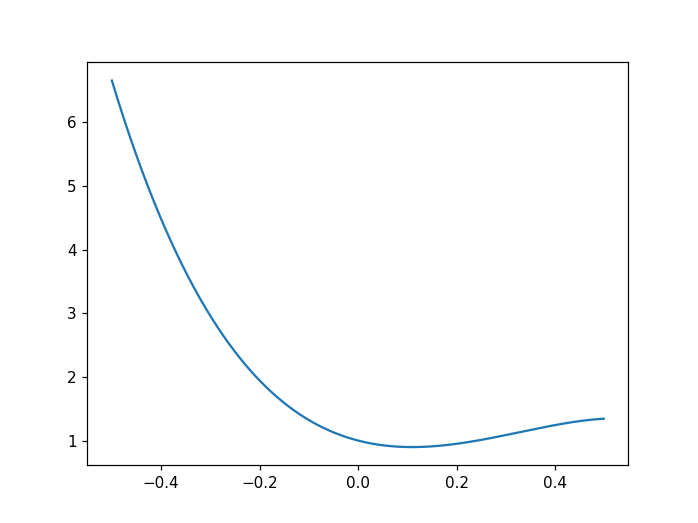

xmin= 0.109859916687


In [17]:
def loss1(x):
    return -5*x**5 + 4*x**4 - 12*x**3 + 11*x**2 - 2*x + 1

dx = 0.001
domain = np.arange(-0.5,0.5,dx)
plt.figure()
plt.plot(domain,loss1(domain));

res = minimize(loss1, 0, method='nelder-mead', options={'xtol': 1e-8, 'disp': False})
loss1Min = res.x[0]
print('xmin=',res.x[0])

# Questão 4.3
Função de custo: 
$f(x)= \log^2(x-2) + \log^2(10-x) - x^{0.2} $

Intervalo: 
$[6,9.9]$

Região de incerteza:
$10^{-5}$

<IPython.core.display.Javascript object>


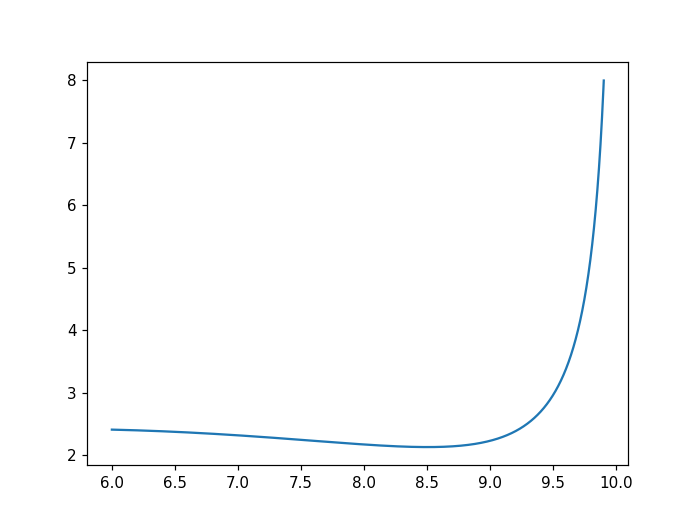

xmin= 8.50158653259


In [18]:
def loss2(x):
    return (sp.log(x-2))**2 + (sp.log(10-x))**2 - x**0.2

x = sp.symbols('x')
dCost = sp.lambdify(x, sp.diff(loss2(x), x),  modules=['numpy'])
cost = sp.lambdify(x, loss2(x), modules=['numpy'])

dx = 0.001
domain = np.arange(6,9.9,dx)
plt.figure()
plt.plot(domain,cost(domain));

res = minimize(loss2, 8, method='nelder-mead', options={'xtol': 1e-8, 'disp': False})
loss2Min = res.x[0]
print('xmin=',res.x[0])

# Questão 4.4
Função de custo:
$f(x)= -3x\sin(0.75x) +\exp(-2x) $

Intervalo: 
$[0,2\pi]$

Região de incerteza:
$10^{-5}$

<IPython.core.display.Javascript object>


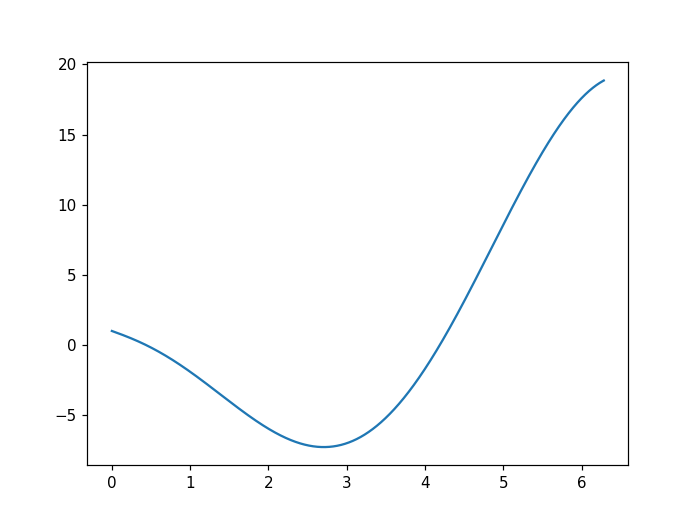

xmin= 2.70647557637


In [19]:
def loss3(x):
    return -3*x*sp.sin(0.75*x)+sp.exp(-2*x)

x = sp.symbols('x')
dCost = sp.lambdify(x, sp.diff(loss3(x), x),  modules=['numpy'])
cost = sp.lambdify(x, loss3(x), modules=['numpy'])

dx = 0.001
domain = np.arange(0,2*np.pi,dx)
plt.figure()
plt.plot(domain,cost(domain));

res = minimize(loss3, sp.pi, method='nelder-mead', options={'xtol': 1e-8, 'disp': False})
loss3Min = res.x[0]
print('xmin=',res.x[0])

### Resultados

In [20]:
columnName = arrays =  [['loss1', 'loss1', 'loss1', 'loss1', 'loss1', 
                         'loss2', 'loss2', 'loss2', 'loss2', 'loss2', 
                         'loss3', 'loss3', 'loss3', 'loss3', 'loss3'],
                       ['x*', 'x err', 'f(x*)', 'func evals', 'grad evals',
                        'x*', 'x err', 'f(x*)', 'func evals', 'grad evals',
                        'x*', 'x err', 'f(x*)', 'func evals', 'grad evals']]

df = pd.DataFrame(index=['Dichotomous', 'Fibonacci','Golden-section',
                         'Quadratic interpolation','Cubic interpolation',
                         'Davies-Swann-Campey', 'Backtracking line'],
                          columns = columnName)
#                           columns=['loss1','nbEval1','loss2','nbEval2','loss3','nbEval3'])

funcs = [[[loss1, loss1Min], [-0.5,0.5], 24], [[loss2, loss2Min], [6,9.9], 25],
         [[loss3, loss3Min], [0,2*np.pi], 25]]
algos = [dichoSearch, fiboSearch, goldenSearch, quadraticSearch,
         cubicSearch, dscSearch, generalDescentMethod]
for algoIdx, algo in enumerate(algos):
    for lossIdx, lossPair in enumerate(funcs):
        loss = lossPair[0][0]
        xmin = lossPair[0][1]
        bounds = lossPair[1]
        if algoIdx == 1:
            x, fx, nbEval, nbDfEval = algo(bounds[0],bounds[1],loss,lossPair[2])
        else:
            x, fx, nbEval, nbDfEval = algo(bounds[0],bounds[1],loss)
        df.iloc[algoIdx][5*lossIdx] = x
        df.iloc[algoIdx][5*lossIdx + 1] = np.abs(x - xmin)
        df.iloc[algoIdx][5*lossIdx + 2] = fx
        df.iloc[algoIdx][5*lossIdx + 3] = nbEval
        df.iloc[algoIdx][5*lossIdx + 4] = nbDfEval
            
df

loss1                                    \
                               x*        x err     f(x*) func evals   
Dichotomous              0.109859  7.79713e-07  0.897633         36   
Fibonacci                 0.10985   9.8667e-06  0.897633         23   
Golden-section           0.109858  2.22548e-06  0.897633         25   
Quadratic interpolation  0.109862   1.9697e-06  0.897633         13   
Cubic interpolation       0.10986   1.5956e-09  0.897633          6   
Davies-Swann-Campey      0.109855  5.00709e-06  0.897633         13   
Backtracking line        0.109859  4.50134e-07  0.897633         37   

                                      loss2                                   \
                        grad evals       x*        x err    f(x*) func evals   
Dichotomous                      0  8.50159  8.15478e-07  2.13384         40   
Fibonacci                        0  8.50154  4.52576e-05  2.13384         24   
Golden-section                   0  8.50159  4.26176e-06  2.13384         28   
Quadratic interpolation          0  8.50142  0.000164171  2.13384        150   
Cubic interpolation              3  8.50159  2.82724e-08  2.13384          8   
Davies-Swann-Campey              0  8.50778   0.00619067  2.13385         20   
Backtracking line                4  8.50159   3.8147e-07  2.13384        121   

                                      loss3                                   \
                        grad evals       x*        x err    f(x*) func evals   
Dichotomous                      0  2.70648   3.9225e-08 -7.27436         40   
Fibonacci                        0  2.70648  4.69607e-06 -7.27436         24   
Golden-section                   0  2.70648  2.02702e-06 -7.27436         29   
Quadratic interpolation          0  2.70648  4.69421e-07 -7.27436         12   
Cubic interpolation              4  2.70648  8.76583e-10 -7.27436          6   
Davies-Swann-Campey              0  2.70648  3.14618e-06 -7.27436         21   
Backtracking line               11  2.70648  1.26301e-06 -7.27436         73   

                                    
                        grad evals  
Dichotomous                      0  
Fibonacci                        0  
Golden-section                   0  
Quadratic interpolation          0  
Cubic interpolation              2  
Davies-Swann-Campey              0  
Backtracking line                7

Na tabela acima estão explicitados para cada função custo e cada algoritmo, o mínimo *f(x*\**)* encontrado e seu minimizador *x*\*, além de o número total de avaliações da função custo *nbEvals* e o número total de avaliações de sua derivada *nbDiffEvals*.

Tanto nos algoritmos *Davis Swann Campey* e *Bactracking line search*, quanto no *método geral do descendente*, os pontos iniciais escolhidos são sempre o ponto médio entre os limites superior e inferior da região de busca. De forma similar, nos algoritmos de interpolação, ao iniciar, escolhe-se tais limites e a dita média para calcular as aproximaçöes.

A escolha padrão de parâmetros para o algoritmo *Backtracking line search* foi fixada da seguinte forma: $ \alpha = 0.15 $ e $ \beta = 0.5 $.

Nota-se que a função custo 2 apresenta certo tipo de desafio para o algoritmo *interpolação quadrática*, pois requer 150 avalicões da função custo e apesar do elevado número de avaliações, o minimizador encontrado dista $2\times10^{-4}$ da solução encontrada pelo algoritmo simplex Nelder-Mead. O algoritmo *Davies Swann Campey* também apresenta um erro de $6\times10^{-3}$ para a segunda função custo.

# Questão 4.11
Função de custo: 
$f(x)= 0.7x^4 - 8*x^2 + 6*y^2 + \cos(xy) - 8x $

## A.

<IPython.core.display.Javascript object>


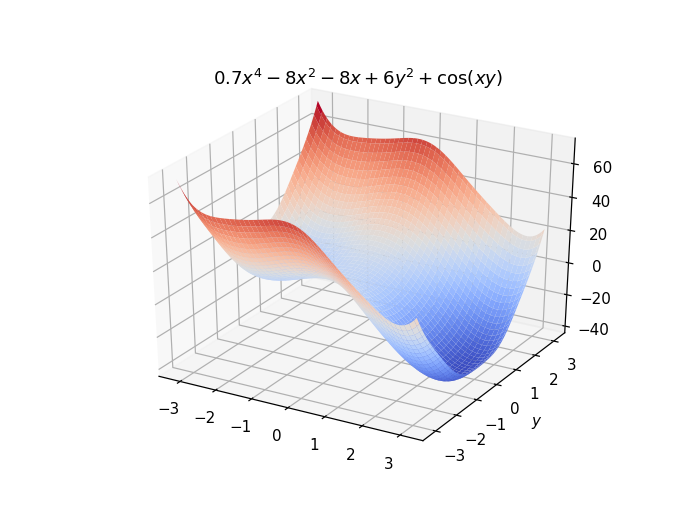

In [21]:
def loss4(x,y):
    return 0.7*(x**4) - 8*(x**2) + 6*(y**2) + sp.cos(x*y) - 8*x

x, y = sp.symbols('x y')
cost = sp.lambdify((x,y), loss4(x,y), modules=['numpy'])
domain = np.linspace(-np.pi,np.pi,100)
X, Y = np.meshgrid(domain, domain)
Z = cost(X,Y)

# ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
#                 cmap='cubehelix', edgecolor='none')
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Z, cmap=plt.cm.coolwarm)
ax.set_ylabel('$%s$' % sp.latex(x))
ax.set_ylabel('$%s$' % sp.latex(y))
ax.set_title('$%s$' % sp.latex(loss4(x,y)));

## B.

<IPython.core.display.Javascript object>


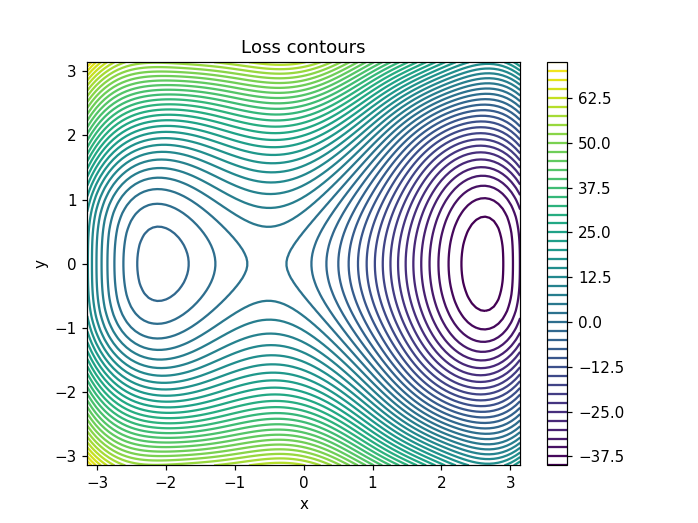

In [22]:
plt.figure()
plt.contour(X, Y, Z, 50)
plt.colorbar()
plt.title('Loss contours')
plt.xlabel('x')
plt.ylabel('y');

## D.

In [23]:
def fletcherLineSearch(x0,dK,costSymbolic,sigma=0.5):

    x, y = sp.symbols('x y')
    cost = sp.lambdify((x,y),costSymbolic(x,y),'numpy')
    gradCost = sp.lambdify([x,y],[sp.diff(costSymbolic(x,y),var) for var in (x,y)],'numpy')
    hessianCost = sp.lambdify([x,y],sp.hessian(costSymbolic(x,y),[x,y]),'numpy')

    # Recommended (Antoniou pp.114)
    rho = 0.1
    tau = 0.1
    chi = 9

    alphaL = 0
    alphaU = np.inf
    g0 = np.array(gradCost(x0[0],x0[1]))
    H0 = np.array(hessianCost(x0[0],x0[1]))
    NbEval = 1
    NbDiffEval = 1
    maxItr = 20
    itr = 0
    
    # Step 1
    xAux = x0 + alphaL*dK

    # Step 2
    fL = np.array(cost(xAux[0],xAux[1]))
    dfL = np.vdot(gradCost(xAux[0],xAux[1]),dK)
    NbEval += 1
    NbDiffEval += 1

    # Step 3
    alphaZeroVals = []
    alphaZero = np.vdot(g0,g0)/np.vdot(g0,H0.dot(g0))
    alphaZeroVals.append(alphaZero)

    while itr < maxItr:
        itr += 1
        
        # Step 4
        xAux = x0 + alphaZero*dK
        f0 = cost(xAux[0],xAux[1])
        NbEval += 1
        # Step 5 (Interpolation)
        if f0 > fL + rho*(alphaZero - alphaL)*dfL:
            if alphaZero < alphaU:
                alphaU = alphaZero

            alphaZeroHat = alphaL + (((alphaZero - alphaL)**2)*dfL)/\
                                    (2*(fL - f0 + (alphaZero - alphaL)*dfL))

            if alphaZeroHat < alphaL + tau*(alphaU - alphaL):
                alphaZeroHat = alphaL + tau*(alphaU - alphaL)

            if alphaZeroHat > alphaU - tau*(alphaU - alphaL):
                alphaZeroHat = alphaU - tau*(alphaU - alphaL)
            alphaZero = alphaZeroHat
            alphaZeroVals.append(alphaZero)
            continue

        # Step 6
        xAux = x0 + alphaZero*dK
        df0 = np.vdot(gradCost(xAux[0],xAux[1]),dK)
        NbDiffEval += 1

        # Step 7 (Extrapolation)
        if df0 < sigma*dfL:
            deltaAlphaZero = ((alphaZero - alphaL)*df0)/(dfL - df0)

            if deltaAlphaZero < tau*(alphaZero - alphaL):
                deltaAlphaZero = tau*(alphaZero - alphaL)

            if deltaAlphaZero > chi*(alphaZero - alphaL):
                deltaAlphaZero = chi*(alphaZero - alphaL)

            alphaZeroHat =  alphaZero + deltaAlphaZero
            alphaL = alphaZero
            alphaZero = alphaZeroHat
            alphaZeroVals.append(alphaZero)
            fL = f0
            dfL = df0
        else:
            break
        
    # Step 8
    xout = x0 + alphaZero*dK
    f0 = cost(xout[0],xout[1])
    
    return itr, alphaZeroVals, f0, nbEval, NbDiffEval

initial point x0: ( -3.14159265359 , 3.14159265359 )
initial value f(x0): 72.6772107884

updated point x1: ( -1.45588677738 , 0.950175014511 )
updated value f(x1): 3.43850400798

final alpha: 1.68570587621
nb iter: 4 	nb eval: 73


<IPython.core.display.Javascript object>


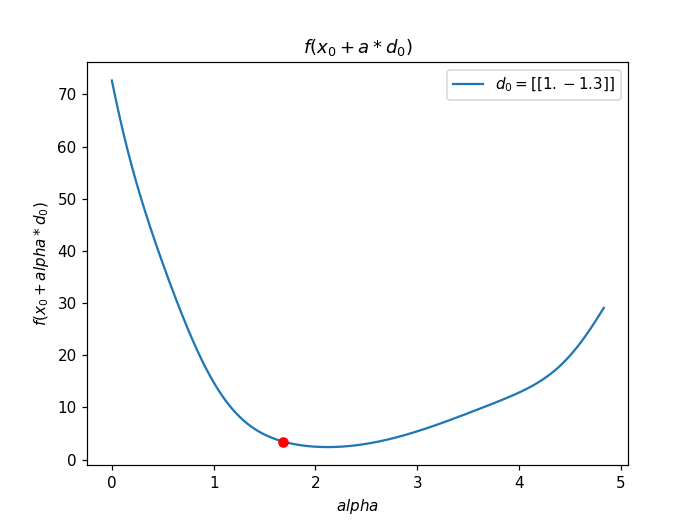

<IPython.core.display.Javascript object>


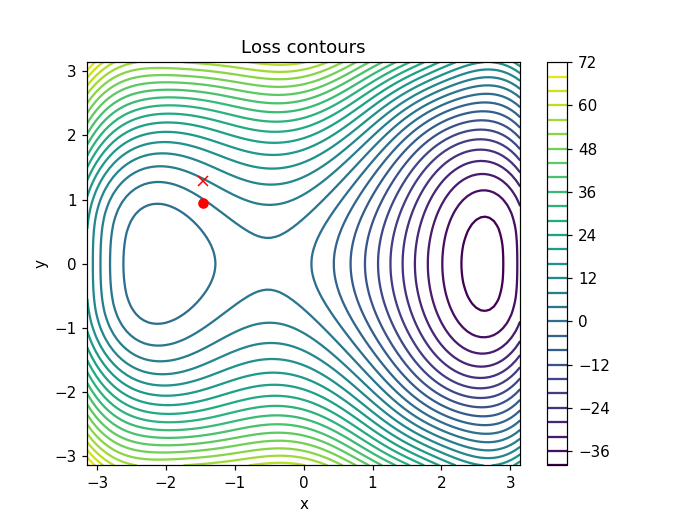

In [25]:
x0 = np.array((-1.0,1.0))*np.pi
d0 = np.array((1.0,-1.3))
fx0 =  cost(x0[0], x0[1])

nbItr, alphaVals, fx1,nbEval, __ = fletcherLineSearch(x0,d0,loss4)
x1 = x0 + alphaVals[-1]*d0

print('initial point x0: (',x0[0],',',x0[1],')')
print('initial value f(x0):',fx0)
print('\nupdated point x1: (',x1[0],',',x1[1],')')
print('updated value f(x1):',fx1)
print('\nfinal alpha:', alphaVals[-1])
print('nb iter:', nbItr,'\tnb eval:', nbEval)

alphas = np.linspace(0,4.8332,48333)
alphas = np.expand_dims(alphas, axis=1)
x0 = np.expand_dims(x0, axis=0)
d0 = np.expand_dims(d0, axis=0)
k = (x0 + alphas*d0).T

plt.figure()
plt.plot(alphas,cost(k[0,:],k[1,:]), label='$d_0=%s$' % sp.latex(d0))
plt.plot(alphaVals[-1],fx1,'ro')
plt.legend()
plt.title('$f(x_0+a*d_0)$');
plt.xlabel('$alpha$');
plt.ylabel('$f(x_0+alpha*d_0)$');

plt.figure()
plt.contour(X, Y, Z, 30)
plt.plot(x1[0],x1[1],'ro')
plt.colorbar()
plt.title('Loss contours')
plt.xlabel('x')
plt.ylabel('y');

## E.

initial point x0: ( -3.14159265359 , 3.14159265359 )
initial value f(x0): 72.6772107884

updated point x1: ( -1.45588677738 , 1.28731618975 )
updated value f(x1): 7.81879805305

final alpha: 1.68570587621
nb iter: 4 	nb eval: 73


<IPython.core.display.Javascript object>


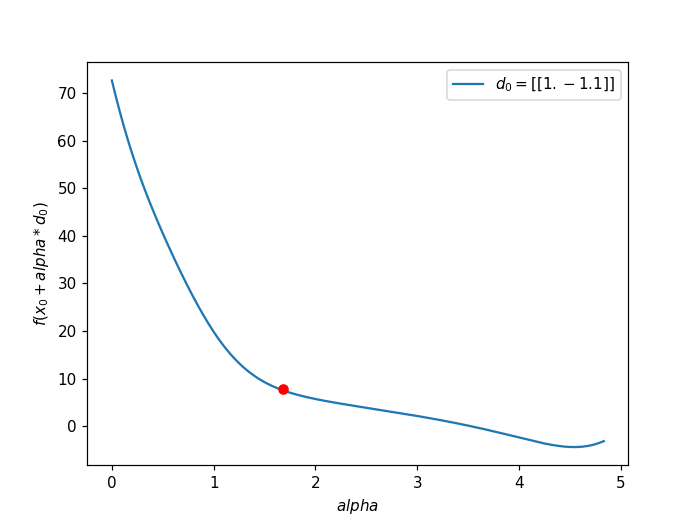

In [26]:
x0 = np.array((-1.0,1.0))*np.pi
d0 = np.array((1.0,-1.1))
fx0 =  cost(x0[0], x0[1])

nbItr, lphaVals, fx1,nbEval, __ = fletcherLineSearch(x0,d0,loss4)
x1 = x0 + alphaVals[-1]*d0
plt.plot(x1[0],x1[1],'rx')

print('initial point x0: (',x0[0],',',x0[1],')')
print('initial value f(x0):',fx0)
print('\nupdated point x1: (',x1[0],',',x1[1],')')
print('updated value f(x1):',fx1)
print('\nfinal alpha:', alphaVals[-1])
print('nb iter:', nbItr,'\tnb eval:', nbEval)

alphas = np.linspace(0,4.8332,48333)
alphas = np.expand_dims(alphas, axis=1)
x0 = np.expand_dims(x0, axis=0)
d0 = np.expand_dims(d0, axis=0)
k = (x0 + alphas*d0).T

plt.figure()
plt.plot(alphas,cost(k[0,:],k[1,:]), label='$d_0=%s$' % sp.latex(d0))
plt.plot(alphaVals[-1],fx1,'ro')
plt.legend()
plt.xlabel('$alpha$');
plt.ylabel('$f(x_0+alpha*d_0)$');

Notamos que na primeira direção escolhida ($[1.0,-1.3]$) $\alpha$ está próximo do valor ótimo e a busca (inexata). Ainda assim, o novo valor de x (ponto $o$ no gráfico de curvas de nível) localiza-se na bacia de atração de um mínimo local da função custo.

No entanto, observamos que no segundo caso o valor ótimo é 4.5, e o encontrado ainda é distante. Como o $\sigma=0.5$ é um valor relativamente alto, a busca é relativamente grosseira e, portanto, nem mesmo quando se escolhe uma melhor direção, i.e $[1.0,-1.1]$, em que potencialmente é possível encontrar o mínimo global (ponto $x$ no gráfico de curvas de nível), o algoritmo proposto por Fletcher consegue adentrar a bacia deste mínimo.